In [ ]:
#Need to choose N, p, m, and k

import random
import matplotlib.pyplot as plt
import numpy as np
import math


#p >= N
N = 2**31-2
p = 2**31 -1
#Placeholder values, I am not sure yet
k = 5
m = 10000

#for part 2
#n = 100000
#c= 10 # said in class



def getPairs(k_val, p_val):
  pairs = [];
  for i in range(k_val):
      a = random.randint(1, p_val-1) # as per instructions for range
      b = random.randint(0,p_val-1)
      pairs.append((a,b)) # arrays of pairs

  return pairs

def hashtype1(m_val,p_val,x,pairs):
  hashes = []
  for a,b in pairs:
      hx = (((a * x) + b) % p_val) % m_val
      hashes.append(hx)

  return hashes # array of all indices that need to be filled in the table


def getSeeds(k_val):
  seeds = [];
  for i in range(k_val):
      s = random.randint(0, 2**32 - 1) # large range for seeds too?
      seeds.append(s)

  return seeds


def hashtype2(x,seeds, m_val):
  hashes = []
  for s in seeds:
      #rgen = random.Random() # looked up how to seed and use random generators
      random.seed(s+x) # start getting random numbers from this index

      hx = random.randint(0, m_val - 1)
      hashes.append(hx)

  return hashes


# Time to test


pairs = getPairs(k,p)
seeds = getSeeds(k)

#first 2000 even numbers

input_size = 2000
data = []
for i in range(input_size):
  data.append(i*2)

rdata = []
for i in range(input_size):
  rdata.append(random.randint(0,N))

# for both hash functions

x1_vals = []
y1_vals = []
x2_vals = []
y2_vals = []
x3_vals = []
y3_vals = []
x4_vals = []
y4_vals = []

# for all k
'''
for x in data:
    hash1 = hashtype1(m,p,x,pairs)
    for h in hash1:
        x1_vals.append(x)
        y1_vals.append(h)

    hash2 = hashtype2(x,seeds,m)
    for h in hash2:
        x2_vals.append(x)
        y2_vals.append(h)
'''

# for first hash function on each input
for x in data:
  hash1 = hashtype1(m,p,x,pairs)
  x1_vals.append(x)
  y1_vals.append(hash1[0])

  hash2 = hashtype2(x,seeds,m)
  x2_vals.append(x)
  y2_vals.append(hash2[0])


for x in rdata:
  hash1 = hashtype1(m,p,x,pairs)
  x3_vals.append(x)
  y3_vals.append(hash1[0])

  hash2 = hashtype2(x,seeds,m)
  x4_vals.append(x)
  y4_vals.append(hash2[0])





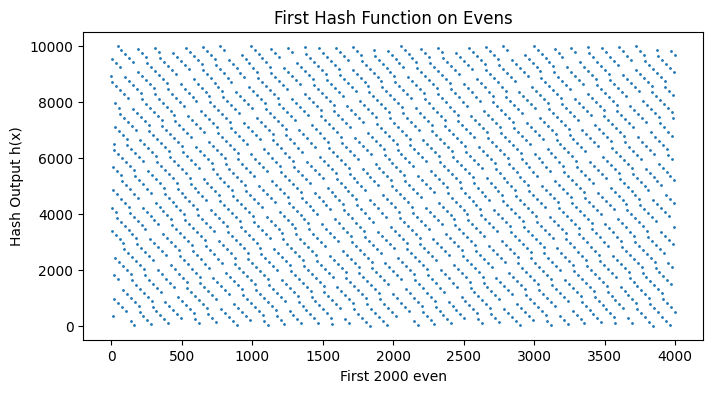

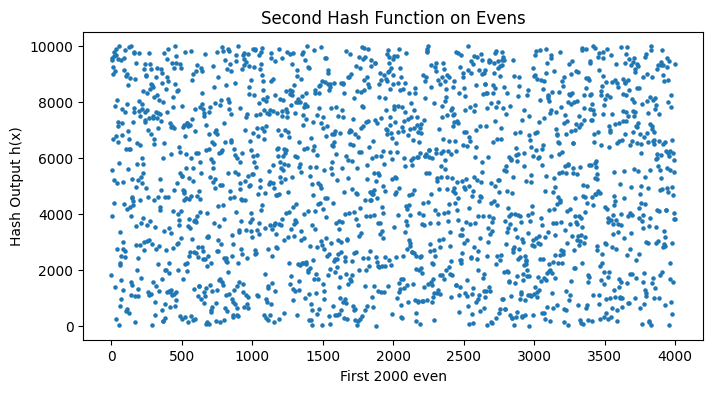

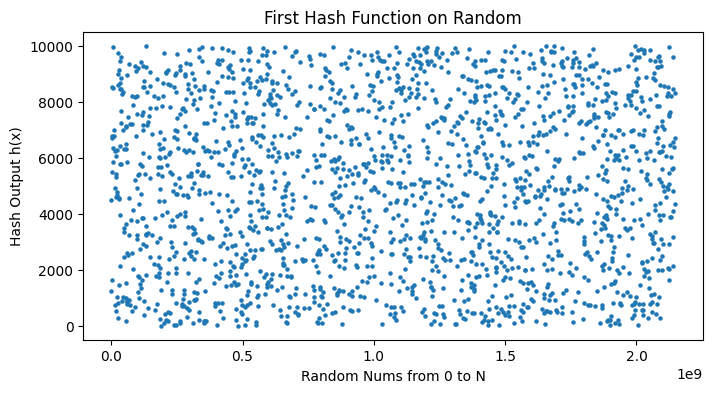

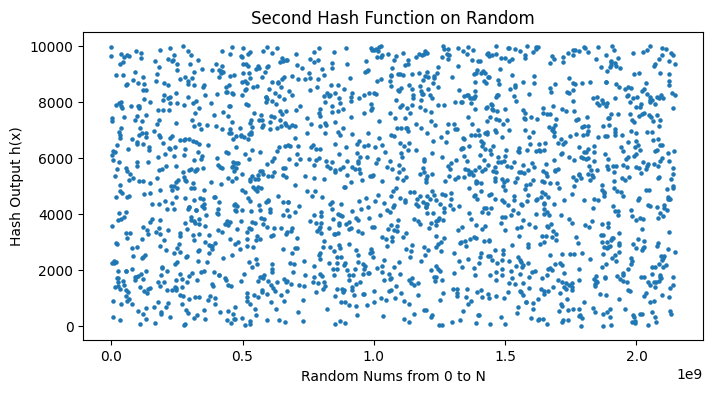

In [ ]:
#Plotting

plt.figure(figsize=(8,4))
#looked up how to make dots smaller use s
plt.scatter(x1_vals,y1_vals,s=1)
plt.title("First Hash Function on Evens")

plt.xlabel("First 2000 even")
plt.ylabel("Hash Output h(x)")


plt.show()


plt.figure(figsize=(8,4))
plt.scatter(x2_vals,y2_vals,s=5)
plt.title("Second Hash Function on Evens")

plt.xlabel("First 2000 even")
plt.ylabel("Hash Output h(x)")


plt.show()


plt.figure(figsize=(8,4))
plt.scatter(x3_vals,y3_vals,s=5)
plt.title("First Hash Function on Random")

plt.xlabel("Random Nums from 0 to N")
plt.ylabel("Hash Output h(x)")

plt.show()

plt.figure(figsize=(8,4))
plt.scatter(x4_vals,y4_vals,s=5)
plt.title("Second Hash Function on Random")

plt.xlabel("Random Nums from 0 to N")
plt.ylabel("Hash Output h(x)")

plt.show()

In [ ]:
#Part 2 , make a bloomfilter class, or else I would have to make multiple functions and call them
#looked up how to initialize an object in a class, use init
class BloomFilter:
  def __init__(self,n,c,k,hash_type):
    self.n = n
    self.c = c
    self.k = k
    self.hash_type = hash_type
    # m = cn
    self.m = c*n
    self.table = [0] * self.m # initializes all to 0
    self.p = p

    if self.hash_type == "type1":
      self.hash_params = getPairs(self.k,self.p)
    elif self.hash_type == "type2":
      self.hash_params = getSeeds(self.k)

  def hash(self,x):
    if self.hash_type == "type1":
      return hashtype1(self.m, self.p,x,self.hash_params)
    else:
      return hashtype2(x,self.hash_params,self.m)

  def add(self,x):
    hashes = self.hash(x)
    for i in hashes:
      self.table[i] = 1 # for each k set pos to 1 in table

  def contains(self,x):
    hashes = self.hash(x)
    for i in hashes:
      if self.table[i] == 0:
        return False

    return True #false positive here?






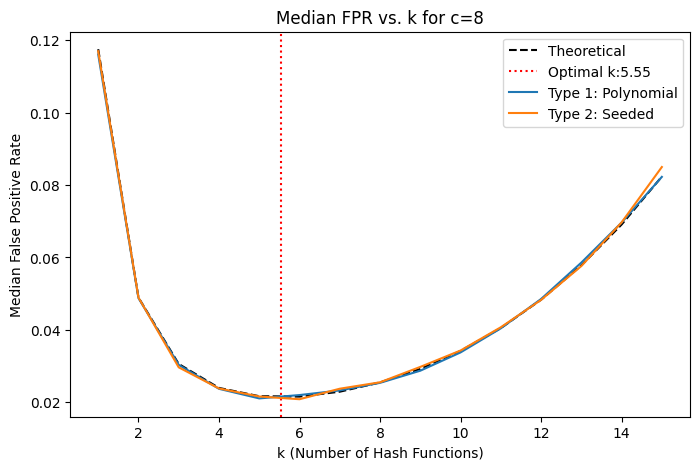

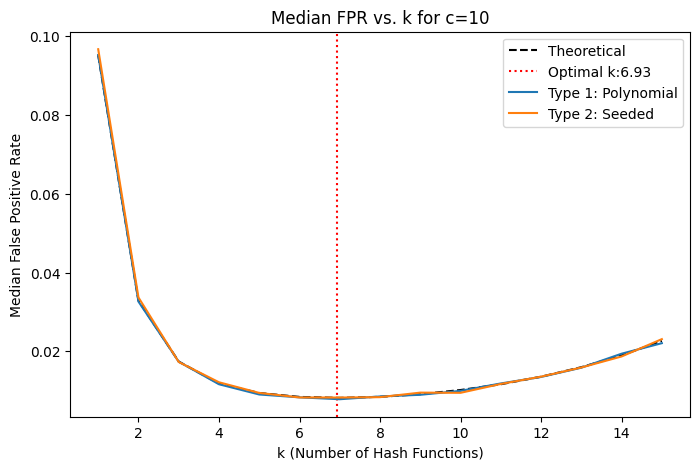

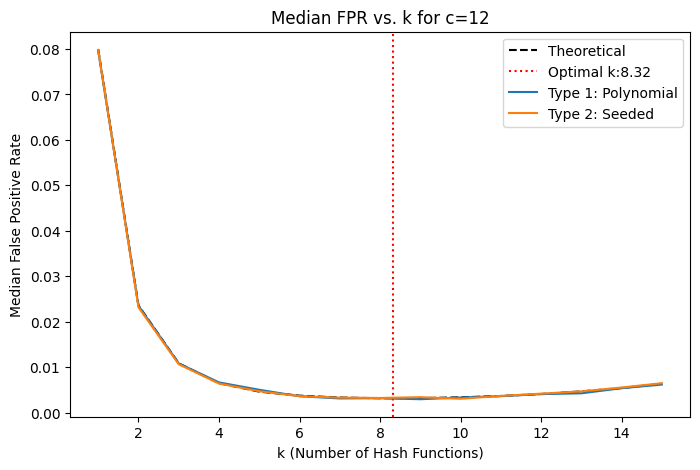

In [ ]:
#Theoretical False Positive Rate: f = (1-e^-k/c)^k
#Optimal k: c * ln(2)

def theoreticalFPR(c,k):
  return(1.0 - math.exp(-k/c)) ** k

def theoretical_k(c):
  return c * math.log(2)

n = 10000
c_vals = [8,10,12]
k_range = range(1,16)
num_trials = 10
queries = 20000
#900 trials
results = {}
for hash_type in ["type1","type2"]:
  results[hash_type] = {}
  for c in c_vals:
    results[hash_type][c] = [] #Store the k,fpr median pair

    for k in k_range:
      fprs = []

      for i in range(num_trials):
        bloom = BloomFilter(n,c,k,hash_type)

        S = set()
        for j in range(n):
          element = random.randint(0, N-1) # populate S and bloom filter to get ready to test for false pos
          S.add(element)
          bloom.add(element)

        false_pos = 0
        not_in_S = 0

        for a in range(queries):
          query = random.randint(0,N-1)
          if query not in S:
            not_in_S += 1
            if bloom.contains(query):
              false_pos += 1

        if not_in_S > 0:
          fpr = false_pos / not_in_S # find fpr rate of this trial
          fprs.append(fpr)

      if fprs:
        medianFPR = np.median(fprs)
        results[hash_type][c].append((k,medianFPR))



# Want to generate 3 plots for c values containing experimental FPR Type 1 and 2, Theo FPR, and optimal k

for c in c_vals:
  plt.figure(figsize = (8,5))
  k_opt = theoretical_k(c)
  #looked up how to plot values and make vertical lines
  #plt.plot(x,y,label,color,dashed line)
  plt.plot(k_range, [theoreticalFPR(c, k) for k in k_range], label='Theoretical', color='k', ls='--')

  #vertical line for optimal k

  plt.axvline(x = k_opt, color = 'red', ls = ':', label = f'Optimal k:{k_opt:.2f}')

  k_vals = [stuff[0] for stuff in results["type1"][c]]
  fpr_type1 = [stuff[1] for stuff in results["type1"][c]] #medians for each type into a list
  fpr_type2 = [stuff[1] for stuff in results["type2"][c]]

  plt.plot(k_vals, fpr_type1, label='Type 1: Polynomial')
  plt.plot(k_vals, fpr_type2, label='Type 2: Seeded')

  plt.title(f'Median FPR vs. k for c={c}') # can use f strings to combine variable types
  plt.xlabel('k (Number of Hash Functions)')
  plt.ylabel('Median False Positive Rate')
  plt.legend()
  filename = f"fpr_vs_k_c_{c}.png"
  plt.savefig(filename)




